<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example we will use LSTM and GRU models in TF2 to forecast the Tesla (TSLA) stock price.  It is based on the time series example at https://www.tensorflow.org/tutorials/structured_data/time_series. 

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(1)

In [4]:
print(tf.__version__)

2.1.0


Read in CSV file using Pandas

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/adammoss/MLiS2/master/examples/rnn/TSLA.csv')

In [20]:
len(df)

2429

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Define function to extract many-to-one training data examples

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [16]:
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()

Date
2010-06-29    23.889999
2010-06-30    23.830000
2010-07-01    21.959999
2010-07-02    19.200001
2010-07-06    16.110001
Name: Close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56ae4561d0>],
      dtype=object)

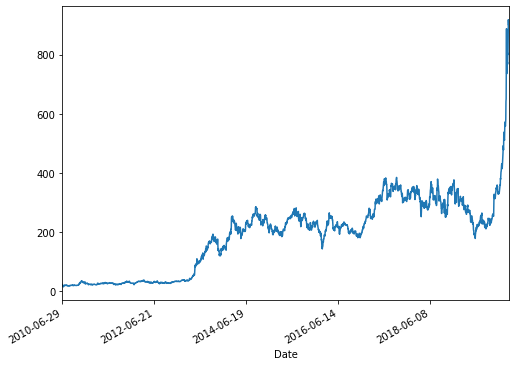

In [17]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

Using first 2000 examples as training data

In [0]:
TRAIN_SPLIT = 2000

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardise the data

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Use the last 20 observations to learn to predict the value at the next time step.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [39]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(1980, 20, 1)
(1980,)
(409, 20, 1)
(409,)


In [29]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target value to predict')
print (y_train_uni[0])

Single window of past history
[[-1.23801939]
 [-1.23855722]
 [-1.25532006]
 [-1.28006089]
 [-1.30775989]
 [-1.31053877]
 [-1.29565841]
 [-1.29619624]
 [-1.29933368]
 [-1.28956283]
 [-1.27432389]
 [-1.2738757 ]
 [-1.26715264]
 [-1.25576825]
 [-1.27020043]
 [-1.27091755]
 [-1.26392556]
 [-1.26132597]
 [-1.26437376]
 [-1.26795941]]

 Target value to predict
-1.2664355126748814


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

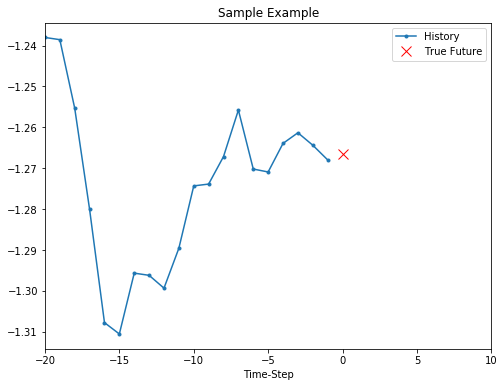

In [32]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:

def build_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(x_train_uni, y_train_uni, epochs=EPOCHS, validation_data=(x_val_uni, y_val_uni))

Train on 1980 samples, validate on 409 samples
Epoch 1/10
1980/1980 [==============================] - 2s 1ms/sample - loss: 1.1015 - mae: 0.9280 - mse: 1.1015 - val_loss: 2.2898 - val_mae: 1.0993 - val_mse: 2.2898
Epoch 2/10
1980/1980 [==============================] - 1s 307us/sample - loss: 0.2837 - mae: 0.4336 - mse: 0.2837 - val_loss: 1.5176 - val_mae: 0.6623 - val_mse: 1.5176
Epoch 3/10
1980/1980 [==============================] - 1s 271us/sample - loss: 0.0543 - mae: 0.1614 - mse: 0.0543 - val_loss: 1.1907 - val_mae: 0.5037 - val_mse: 1.1907
Epoch 4/10
1980/1980 [==============================] - 1s 283us/sample - loss: 0.0283 - mae: 0.1172 - mse: 0.0283 - val_loss: 1.0151 - val_mae: 0.4297 - val_mse: 1.0151
Epoch 5/10
1980/1980 [==============================] - 1s 286us/sample - loss: 0.0191 - mae: 0.0976 - mse: 0.0191 - val_loss: 0.8952 - val_mae: 0.3870 - val_mse: 0.8952
Epoch 6/10
1980/1980 [==============================] - 1s 269us/sample - loss: 0.0141 - mae: 0.0848 - ms

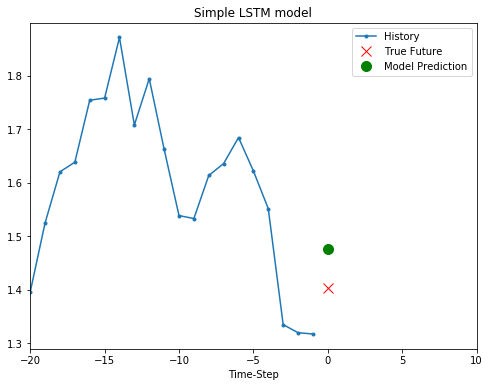

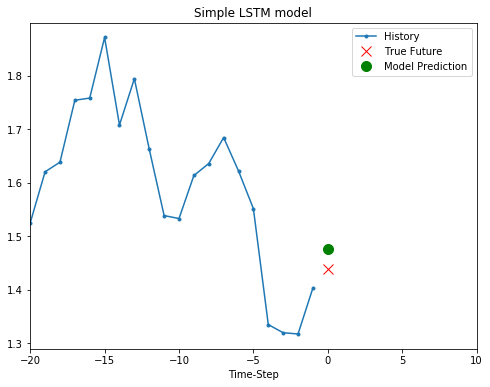

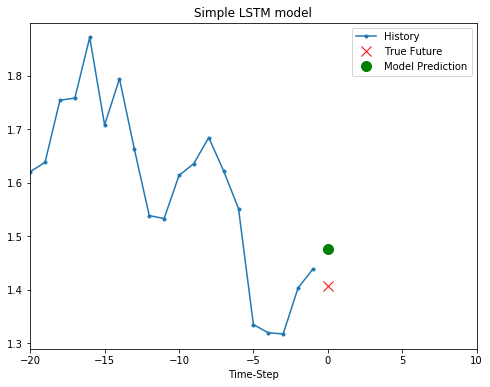

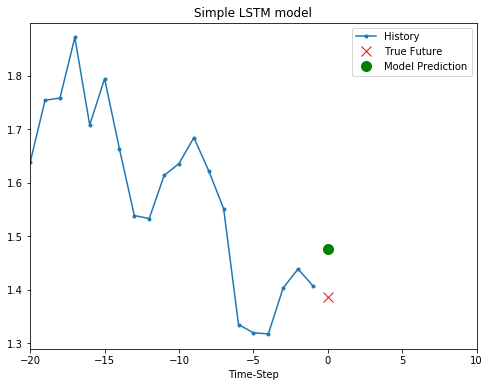

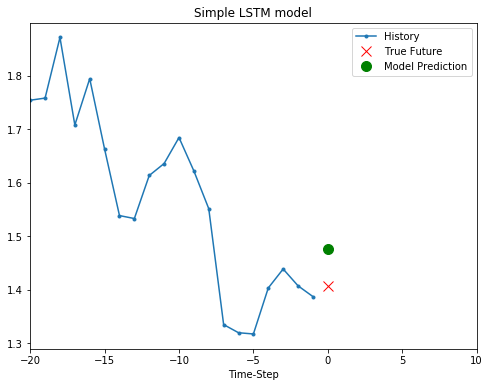

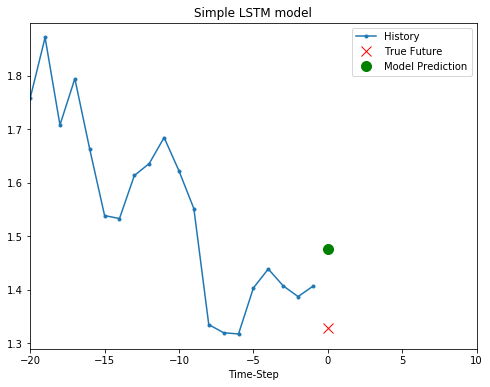

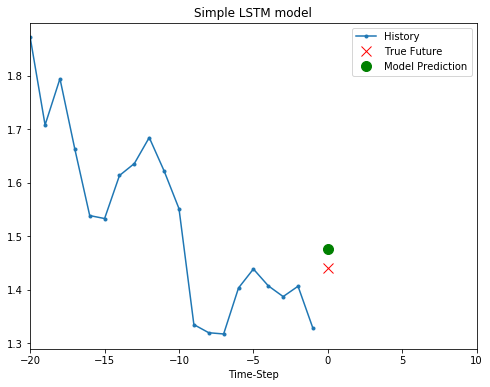

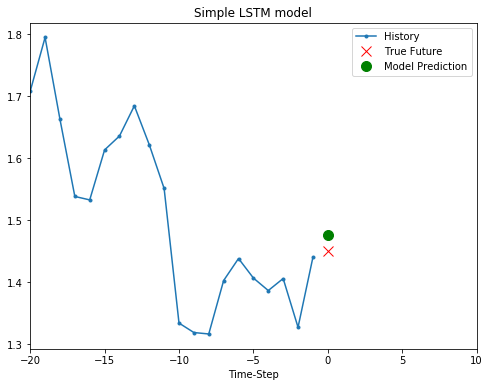

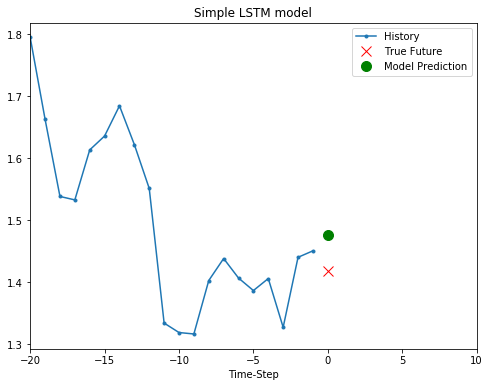

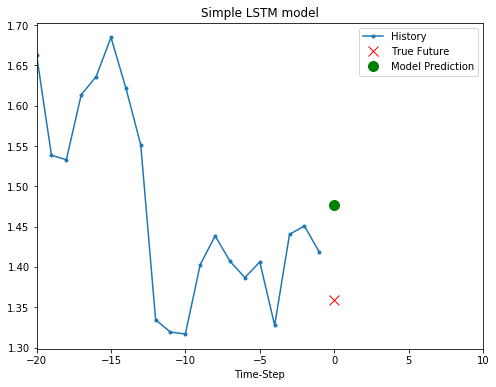

In [59]:
for i in range(10):
  plot = show_plot([x_val_uni[i], y_val_uni[i],
                    model.predict(x_val_uni[0:1])[0]], 0, 'Simple LSTM model')
  plot.show()
